# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import stark

In [5]:
ind_returns = stark.get_ind_returns()

In [8]:
risky_returns = ind_returns.loc["2000":][["steel", "fin", "beer"]]
risky_returns.head()

,steel,fin,beer
2000-01,-0.0277,-0.0442,-0.0228
2000-02,0.0684,-0.0849,-0.1164
2000-03,0.0349,0.1669,0.0013
2000-04,-0.0084,-0.0425,0.0368
2000-05,-0.0492,0.0506,0.1187


In [9]:
safe_returns = pd.DataFrame().reindex_like(risky_returns)
print(safe_returns.shape)

(228, 3)


In [12]:
safe_returns[:] = 0.03 / 12
start = 1_000
floor = 0.8

1. Cushion - (Asset Value minus Floor Value)
2. Compute an allocation to safe and risky assets --> m * risk_budget
3. Recompute the asset value based on the returns

In [18]:
def compound_one(returns):
    return (1 + returns).prod() - 1

def compound_two(returns):
    log_returns_sum = np.log(1 + returns).sum()
    return np.exp(log_returns_sum - 1)

def compound_three(returns):
    return np.expm1(np.log1p(returns).sum())

In [15]:
compound_one(risky_returns)

steel   -0.051696
fin      1.773937
beer     3.361349
dtype: float64

In [19]:
compound_two(risky_returns)

steel    0.348862
fin      1.020474
beer     1.604451
dtype: float64

In [17]:
compound_three(risky_returns)

steel   -0.051696
fin      1.773937
beer     3.361349
dtype: float64

In [32]:
%timeit compound_one(risky_returns)

204 µs ± 5.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
%timeit compound_three(risky_returns)

203 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Back to CPPI

In [36]:
from tqdm import tqdm

dates = risky_returns.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_returns)
cushion_history = pd.DataFrame().reindex_like(risky_returns)
risky_w_history = pd.DataFrame().reindex_like(risky_returns)

for step in tqdm(range(n_steps)):
    cushion = (account_value - floor_value) / account_value
    risky_weight = m * cushion
    risky_weight = np.minimum(risky_weight, 1)
    risky_weight = np.maximum(risky_weight, 0)

    safe_weight = 1 - risky_weight
    
    risky_allocation = account_value * risky_weight
    safe_allocation = account_value * safe_weight
    
    # update account value for this time step
    account_value = (risky_allocation * (risky_returns.iloc[step] + 1)) + \
        (safe_allocation * (safe_returns.iloc[step] + 1))
    
    # save values  
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_weight
    account_history.iloc[step] = account_value
    
    

100%|██████████| 228/228 [00:00<00:00, 1475.33it/s]


In [37]:
account_history.head()

,steel,fin,beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


<AxesSubplot:>

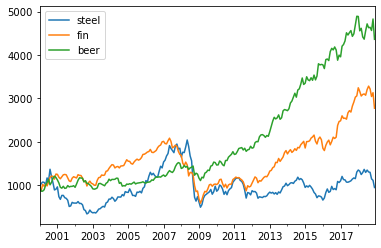

In [40]:
risky_wealth = start * (1 + risky_returns).cumprod()
risky_wealth.plot()

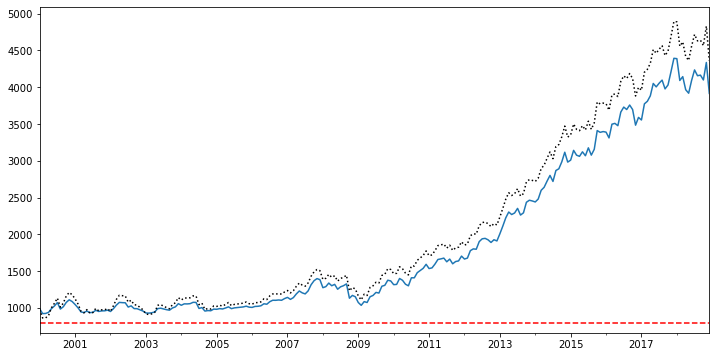

In [43]:
ax = account_history.beer.plot(figsize=(12, 6))
risky_wealth.beer.plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

<AxesSubplot:>

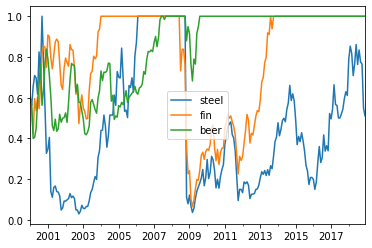

In [44]:
risky_w_history.plot()

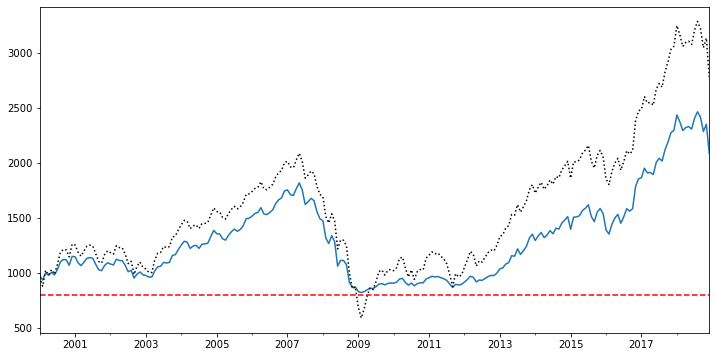

In [45]:
ind = "fin"
ax = account_history[ind].plot(figsize=(12, 6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

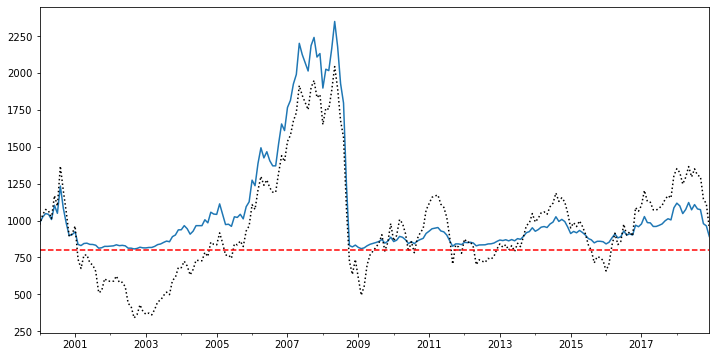

In [46]:
ind = "steel"
ax = account_history[ind].plot(figsize=(12, 6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

In [56]:
stark.summary_stats(risky_returns)

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.006139,-0.102567,-0.758017
fin,0.055166,0.192909,-0.533218,4.995534,0.091224,-0.000094,0.126718,-0.718465
beer,0.080598,0.138925,-0.493545,4.173881,0.063015,-0.001866,0.354314,-0.271368


In [64]:
backtest = stark.run_cppi(risky_returns)

100%|██████████| 228/228 [00:00<00:00, 1576.69it/s]


In [67]:
stark.summary_stats(backtest["wealth"].pct_change().dropna())

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.006710,-0.196750,-0.655198
fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.000420,0.080352,-0.549673
beer,0.075544,0.115462,-0.669250,4.760879,0.052923,-0.001118,0.383772,-0.259582


In [87]:
tmi_returns =  pd.read_csv(
    "total_market_return.csv", 
    header=0, 
    index_col = 0,     
)
tmi_returns.index = pd.to_datetime(
    tmi_returns.index
).to_period("M")

100%|██████████| 144/144 [00:00<00:00, 1488.19it/s]


<AxesSubplot:>

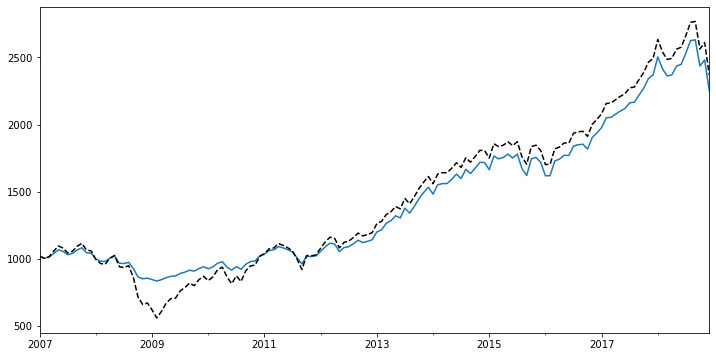

In [92]:
backtest = stark.run_cppi(tmi_returns.loc["2007":])
ax = backtest["wealth"].plot(figsize=(12, 6), legend=False)
backtest["risky_wealth"].plot(ax=ax, style="k--", legend=False)

In [94]:
stark.summary_stats(backtest["risky_wealth"].pct_change().dropna())

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
0,0.073411,0.150463,-0.734939,4.523488,0.071592,-0.004205,0.280618,-0.499943


In [95]:
stark.summary_stats(backtest["wealth"].pct_change().dropna())

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
0,0.069416,0.100381,-0.588292,3.740932,0.045678,-0.003188,0.382052,-0.229683


# Drawdown Constraint

In [97]:
backtest = stark.run_cppi(
    ind_returns.loc["2007":][["steel", "fin", "beer"]], 
    drawdown_constraint = 0.25
)

100%|██████████| 144/144 [00:00<00:00, 1246.48it/s]


<AxesSubplot:>

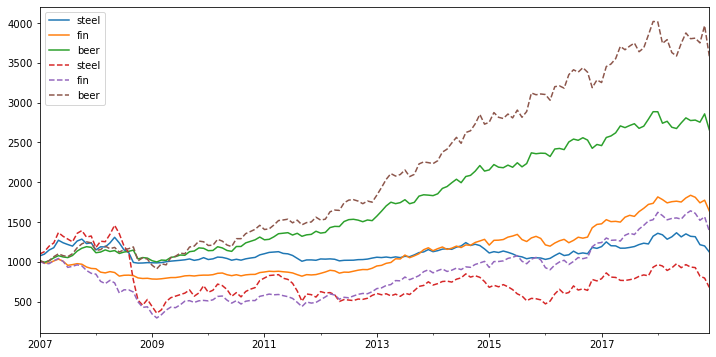

In [98]:
ax = backtest["wealth"].plot(figsize=(12, 6))
backtest["risky_wealth"].plot(ax = ax, style="--")

In [99]:
stark.summary_stats(backtest["risky_wealth"].pct_change().dropna())

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.009735,-0.221642,-0.758017
fin,0.027364,0.212204,-0.695200,4.621401,0.105744,-0.000156,-0.012370,-0.718465
beer,0.111554,0.127971,-0.670797,4.650878,0.056497,-0.000083,0.620132,-0.271368


In [100]:
stark.summary_stats(backtest["wealth"].pct_change().dropna())

,annualized_return,annualized_volatility,skewness,kurtosis,cornish_fisher_var,historic_var,sharpe_ratio,drawdown
steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.002480,-0.262958,-0.248059
fin,0.041975,0.085028,-0.355163,4.153860,0.038342,-0.000943,0.136964,-0.243626
beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.000545,0.613413,-0.161186
